<a href="https://colab.research.google.com/github/ceos-seo/odc-colab/blob/master/notebooks/02.08.03.Colab_S1_SDG_661_WaterExtent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SDG 6.6.1 - Sentinel-1 Water Extent
<br>
This notebook uses Sentinel-1 radar data to detect water extent. Since radar can penetrate clouds, it is possible to get consistent time series views of a region at 6-day or 12-day revisits based on the use of one or two Sentinel-1 missions. If the region of interest falls within a scene overlap, it may be possible to get even more frequent visits. This notebook includes several different data products including histograms to find a good threshold for water detection, a single date VH-band threshold product to identify water extent, and a multi-date change product to identify new flooding.
<br><br>
The core data has been processed by Google Earth Engine using GRD scenes to create C-band backscatter intensity (VV and VH bands) at 10-meters spatial resolution. The data is consistently available from late 2014 for the globe. It is important to note that this data does NOT include radiometric terrain correction (RTC) so there are issues using this data in areas with high elevation variation due to layover and shadowing. It is recommended that users only compare scenes from the same pass direction (ascending or descending) to avoid viewing geometry issues. 

## Instructions for Execution
It is suggested that users first execute the notebook "as is" to successfully complete the Google authorizations and view sample results. Then, users should look for the "MODIFY HERE" labels at the top of several code blocks to identify code that can be modified. These include:<br>
<br>#1 - Define the center and size of the analysis region
<br>#2 - Select a time range to review orbit paths
<br>#3 - Select pixel resolution
<br>#4 - Select a time slice from the coverage summary table to view a sample scene
<br>#5 - Select a time range for the full time series analysis
<br>#6 - Select an orbit number before loading the data
<br>#7 - Select a time slice to view the histogram data
<br>#8 - Select a time slice and VH-band water threshold value
<br><br>
Once the full notebook has been run, users can run individual code blocks using "Shift+Return" (select at the same time) or run segments of the code using the Runtime menu. Users do not have to go thru the Google authorization steps for additional execution cycles. 

In [ ]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

In [ ]:
from odc_colab import populate_db
populate_db()

## Load the Data Cube Configuration and Import Utilities

In [ ]:
# Ignore warnings 
import warnings
warnings.simplefilter('ignore')

# Load Data Cube Configuration
from odc_gee.earthengine import Datacube
dc = Datacube()

# Import Utilities
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.dc_rgb import rgb
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Select and data platform and product
platform = 'Sentinel-1A'
product = 's1_google'

## Define the Extents of the Analysis and View
Select the center of an analysis region (lat_long) below. The size of the region (in degrees) that surrounds this center point is defined using the "box_size_deg" parameter. Users can select one of the sample regions or add a new region. Use the map below to zoom in-or-out to find other regions. Click on the map to view a Lat-Lon position. After selecting an analysis region, you can also select a time window by defining the start date and end date for the "time_extents" parameter.

In [ ]:
#1 MODIFY HERE

# Example Case #1
# Mtera Reservoir, Tanzania, Africa

lat_long = (-7.0395, 35.8377)
box_size_deg = 0.4

# Example Case #2
# Eastern Lake Kariba, Zimbabwe, Africa

# lat_long = (-16.644, 28.746)
# box_size_deg = 0.5

In [ ]:
#2 MODIFY HERE

# Select a short time period to screen the available data and find good orbit paths
# It is suggested that users select 1 month in the desired time window

time_extents = ('2020-01-01', '2020-02-01')

In [ ]:
# Calculate the latitude and longitude bounds of the analysis box
latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)

In [ ]:
display_map(latitude,longitude)

## Load the Data and View the Available Dates
This is where the Sentinel-1 data is loaded with specific parameters. Due to the lack of Radiometric Terrain Correction (RTC), it is advised that one consistent orbit pass direction is used for comparison (e.g. Ascending or Descending). This will ensure the viewing angles are consistent for a given location to avoid false land change detection. By experimenting with the choice of orbit paths and pass directions it may be possible to maximize the available dates for analyses.

In [ ]:
#3 MODIFY HERE

# Loading large amounts of data using resampling requires averaging pixels and changing the output resolution
# Baseline Sentinel-1 resolution = 10 meters per pixel

# resolution = desired output pixel resolution (in meters) after resampling

resolution = 100

In [ ]:
# scale = conversion of resolution to degrees (assumes 111320 m/deg at equator)

scale = resolution / 111320.0 

In [ ]:
# Load a small portion of the data to view the scene output

parameters = dict(product=product, platform=platform, measurements=['vh'],
                  time=time_extents, lat=latitude, lon=longitude, group_by='solar_day',
                  output_crs='EPSG:4326', resolution=(-scale, scale), resampling='average')

sar_dataset = dc.load(**parameters)

In [ ]:
# Query the metadata from the dataset

from operator import itemgetter

def get_metadata(group):
    metadata = (set(), set(), set(), set())
    for ds in group:
        metadata[0].add(np.datetime64(ds.metadata_doc.get('properties').get('dtr:start_datetime'), 'D'))
        metadata[1].add(ds.metadata_doc.get('properties').get('gee:properties').get('orbitProperties_pass'))
        metadata[2].add(ds.metadata_doc.get('properties').get('gee:properties').get('platform_number'))
        metadata[3].add(ds.metadata_doc.get('properties').get('gee:properties').get('relativeOrbitNumber_start'))
    return tuple(map(lambda x: ', '.join([str(i) for i in x]), metadata))

parameters.update(group_by='time' if not parameters.get('group_by') else parameters['group_by'])
sar_metadata = sorted([get_metadata(groups)
                       for groups in dc.group_datasets(dc.find_datasets(**parameters),
                                                       parameters.get('group_by')).values],
                      key=itemgetter(0))

In [ ]:
# Show acquisition indices, dates and orbit information
pd.DataFrame(sar_metadata, columns=['Acquisition Date', 'Pass Direction', 'Mission', 'Orbit Number'])

,Acquisition Date,Pass Direction,Mission,Orbit Number
0,2020-01-04,ASCENDING,A,130
1,2020-01-07,DESCENDING,B,79
2,2020-01-09,ASCENDING,A,28
3,2020-01-16,ASCENDING,A,130
4,2020-01-19,DESCENDING,B,79
5,2020-01-21,ASCENDING,A,28
6,2020-01-28,ASCENDING,A,130
7,2020-01-31,DESCENDING,B,79


## How to review the data and select an orbit number 
Depending on the scene size and location, Sentinel-1 instrument coverage can be complex. In the table above you may see various pass directions (ascending or descending), various missions (A or B) and various orbit numbers. In order to ensure consistent viewing angles, users should select one orbit number for further time series analyses. It is possible that one orbit number is used by both missions (A and B), but that is not always the case. In order to view a sample scene to be sure it adequately covers the region of interest, users should execute the code block below using various time slices to view sample output results. The next section will then load data for the entire time series using a selected orbit number to have a consistent view of the ground.

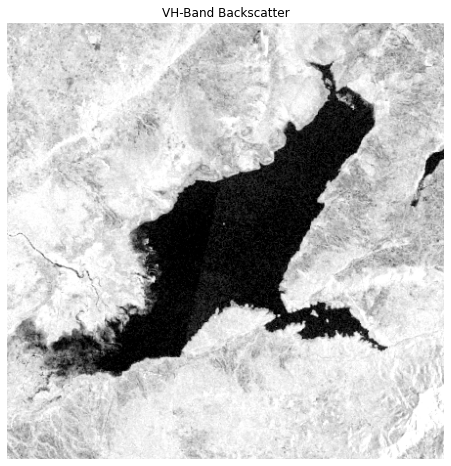

In [ ]:
#4 MODIFY HERE

# Display a VH grey-scale image for one selected time slice
# Choose the time slice from the table above and add the code below (time=)
# To run this single code block, select the cell and then hit: Shift+Return (at the same time)
# Be sure to check all combinations of orbit numbers to get the best possible region coverage

rgb(sar_dataset.isel(time=1), bands=['vh', 'vh', 'vh'], width=8)
plt.title('VH-Band Backscatter')
plt.axis('off')
plt.show()

## Pausing Execution
The code below will pause the notebook to review the scene data and select an orbit number. This orbit number will be used in further analyses to filter the data and maintain a consistent viewing geometry. See the cells above for more details.

In [ ]:
raise Exception("Pause Here")

## How to run the full time series analysis
Once the data has been reviewed and an orbit number has been selected, then we can move forward and do a long time series analysis. The next section of the code below will select a new time period, filter the data to select only the desired orbit number, apply speckle filtering using a block filter, view histogram plots, and view an RGB image. To run this section of the notebook, place your cursor on this cell block and then use the menu to select: Cell > Run All Below.

In [ ]:
# 5 MODIFY HERE

# Select a time period for the full time series analysis by defining the start and end dates
# Data from Sentinel-1 is available from 2014-10-03 to current

time_extents = ('2018-07-15', '2022-01-01')

In [ ]:
#6 MODIFY HERE

# Load the data and select a single orbit number using the query filter below.

# Example Case #1
# Mtera Reservoir, Tanzania, Africa
# Select Orbit #28 or #79

# Example Case #2
# Eastern Lake Kariba, Zimbabwe, Africa
# Select Orbit #145

parameters = dict(product=product, platform=platform, measurements=['vv','vh'],
                  time=time_extents, lat=latitude, lon=longitude, group_by='solar_day',
                  output_crs='EPSG:4326', resolution=(-scale, scale), resampling='average',
                  query={'filter':'relativeOrbitNumber_start=28'})

In [ ]:
# Load the data using the filter parameters above
# This may take a long time depending on the region size and time window size

sar_dataset = dc.load(**parameters)

In [ ]:
# Query the metadata from the dataset

parameters.update(group_by='time' if not parameters.get('group_by') else parameters['group_by'])
sar_metadata = sorted([get_metadata(groups)
                       for groups in dc.group_datasets(dc.find_datasets(**parameters),
                                                       parameters.get('group_by')).values],key=itemgetter(0))

In [ ]:
# Show acquisition indices and dates
pd.set_option('display.max_rows', 250)
pd.DataFrame(sar_metadata, columns=['Acquisition Date', 'Pass Direction', 'Mission', 'Orbit Number'])

,Acquisition Date,Pass Direction,Mission,Orbit Number
0,2018-07-18,ASCENDING,A,28
1,2018-07-30,ASCENDING,A,28
2,2018-08-11,ASCENDING,A,28
3,2018-08-23,ASCENDING,A,28
4,2018-09-04,ASCENDING,A,28
5,2018-09-16,ASCENDING,A,28
6,2018-09-28,ASCENDING,A,28
7,2018-10-10,ASCENDING,A,28
8,2018-10-22,ASCENDING,A,28
9,2018-11-03,ASCENDING,A,28


### Speckle Filtering using a Block Filter
Radar data is often "grainy" in appearance and differences between water and land are not consistent. To improve the data, it is quite common to use speckle filtering. Below is an algorithm that uses a common "block" filter to average the pixels surrounding any given pixel. Users can select an odd number "filter_size" (e.g. 3,5,7, etc.) to filter both the VV and VH data. A block filter size of 3 will average a 3x3 region around every pixel. Similarly, a filter size of 5 will average a 5x5 region around a every pixel. 

In [ ]:
# Setup dB to power conversion functions so that filters work on power values

def to_pwr(x):
    return 10**(x/10)
def to_db(x):
    return 10*np.log10(x)

In [ ]:
# Users can select the "filter_size" to define the level of speckle filtering. The baseline is 5.
# The filter size must be an odd number, such as 3,5,7, etc. 

from utils.data_cube_utilities.raster_filter import stats_filter_2d

# Set any null values to 0 before applying the filter to prevent issues
sar_dataset_filled = sar_dataset.where(~sar_dataset.isnull(), 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
sar_dataset["block_filter_vv"] = sar_dataset_filled.vv.pipe(to_pwr).groupby("time")\
                                 .apply(stats_filter_2d, statistic='mean', filter_size=5)\
                                 .pipe(to_db)
sar_dataset["block_filter_vh"] = sar_dataset_filled.vh.pipe(to_pwr).groupby("time")\
                                 .apply(stats_filter_2d, statistic='mean', filter_size=5)\
                                 .pipe(to_db)

## View Histogram Plots
Histogram plots are good for viewing the statistical backscatter distribution of the VV and VH data. In most cases it is easy to identify the difference between land pixels (higher values) and water pixels (lower values). VV-polarised backscatter may however sometimes be affected by wind and rain effects (which may cause a backscatter increase) which is why the VH polarisation channel is recommended for detection of water. The VH histogram (orange) in the example below will typically show land at a peak near -15 dB and water (dark) at a peak below -30 dB. A reasonable threshold for water detection may be estimated from this histogram by identifying the low point between these two peaks. For example, the baseline case uses a VH threshold of -27 dB for the water and land separation. Users should test this threshold to determine the best value for a particular region or water body.

In [ ]:
#7 MODIFY HERE

# Choose a single time slice by its index (listed in the table above)

time_slice = 0

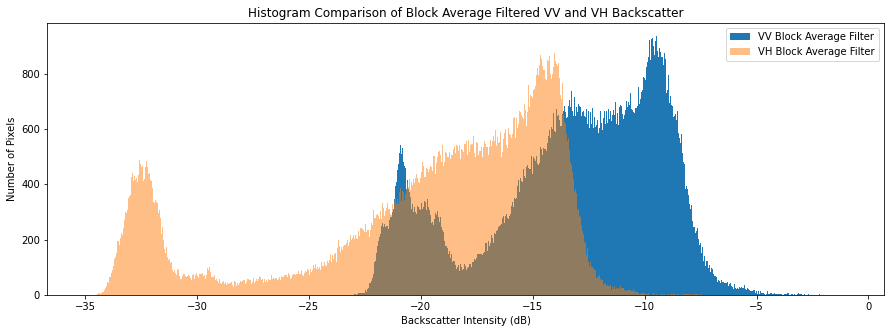

In [ ]:
# View the histogram of VV and VH data

fig = plt.figure(figsize=(15, 5))
sar_dataset.isel(time=time_slice).block_filter_vv.plot.hist(bins=1000,range=(-35,-1),label="VV Block Average Filter")
sar_dataset.isel(time=time_slice).block_filter_vh.plot.hist(bins=1000,range=(-35,-1),label="VH Block Average Filter", alpha=0.5)
plt.legend()
plt.xlabel("Backscatter Intensity (dB)")
plt.ylabel("Number of Pixels")
plt.title("Histogram Comparison of Block Average Filtered VV and VH Backscatter")
plt.show()

## Scale the backscatter amplitude for better image outputs
Backscatter amplitude for each band can be scaled to an 8-bit range of 0-255 to improve visual output and maximize contrast in VV and VH image products. This process is explained here. Gamma-nought backscatter amplitude (in dB units) is converted to raw (digital number) units using the conversion: DN (amplitude) = 10^(dB/20). Histograms are then used to view the range of dB values for the VV and VH bands. The range of expected values (across diverse land types) is then scaled to an 8-bit range using the formula: Scale = 256 / (range). Finally, an "offset" value is applied to allow the full range of values to be distributed across the 8-bit range. The final equation is: DN (amplitude, 8-bit) = ( DN(amplitude) - offset ) * scale. 

In [ ]:
# This backscatter scaling is optimized for block-filtered data
# VV band range is 0dB to -16dB which is DN=1.00 to DN=0.158
# VH band range is -5dB to -27dB which is DN=0.562 to DN=0.045
# VV/VH range is 0.0 to 1.0. This data is scaled by 20 for improved color contrast

vv_convert = (10**(sar_dataset.block_filter_vv/20)-0.158)*303
vh_convert = (10**(sar_dataset.block_filter_vh/20)-0.045)*493
sar_dataset['vv_amp'] = vv_convert
sar_dataset['vh_amp'] = vh_convert
sar_dataset['vvvh_amp'] = (vv_convert / vh_convert) * 20

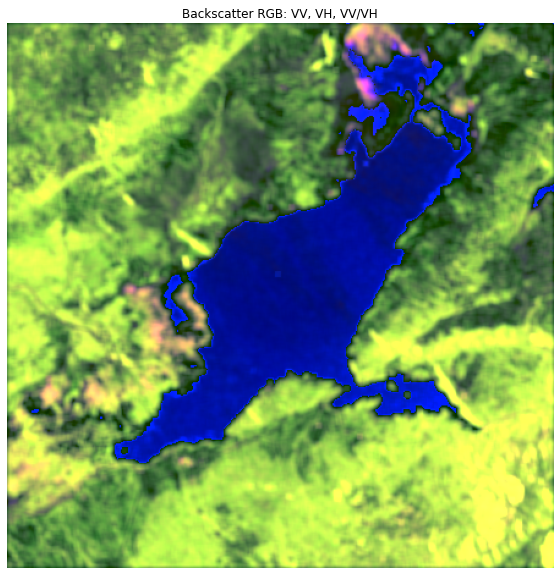

In [ ]:
# RGB Plot of Backscatter Intensity (RGB= VV, VH, VV/VH)
# High backscatter (both bands) due to vegetation and foliage will appear as YELLOW (mix of red and green)
# Urban areas are MAGENTA in color (due to high overall scattering and higher VV compared to VH)
# Low vegetation areas are BLUE (due to low overall scattering and higher VV compared to VH)
# Water is DARK BLUE to BLACK (low backscatter in both bands with similar VV and VH)

rgb(sar_dataset.isel(time=time_slice),bands=['vv_amp','vh_amp','vvvh_amp'], width=10)
plt.title('Backscatter RGB: VV, VH, VV/VH')
plt.axis('off')
plt.show()

## Pausing Execution
The code below will pause the notebook to review the histogram data and select a VH-band water detection threshold. This threshold will be used in further analyses to filter the data and identify water pixels. 

In [ ]:
raise Exception("Pause Here")

## Single Date Single-Band Threshold Water Extent
The code below allows users to select a single date (use the index table above), a single band (e.g. VV or VH), and a water detection threshold value for the selected band. See the histogram section above for more information about selecting a threshold value. The first product below shows the water extent in BLUE against a gray-scale background image. The second product is the time series water surface area. To run the final section of the notebook, place your cursor on this cell block and then use the menu to select: Cell > Run All Below.

In [ ]:
#8 MODIFY HERE

single_date = 1
single_variable = 'block_filter_vh'
water_threshold = -27.0

In [ ]:
color_blue = np.array([0,0,255]) # Water (BLUE)
scene = sar_dataset.isel(time=single_date)
water = scene[single_variable].values < water_threshold
water_pixels = scene[single_variable]
water_count = (water_pixels < water_threshold).sum().values
water_area = water_count * resolution * resolution / 1000 / 1000

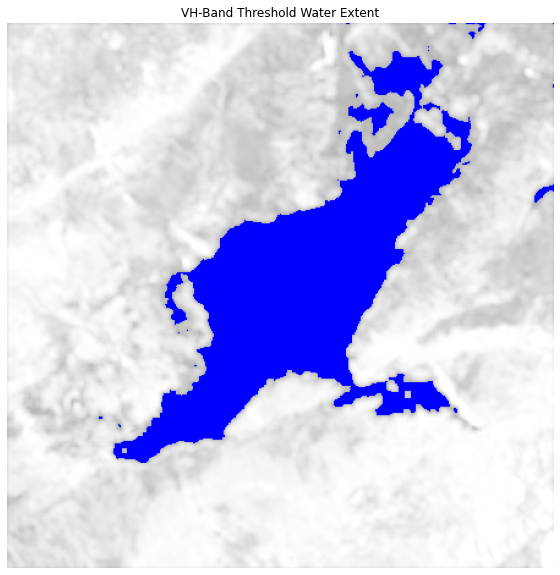

In [ ]:
rgb(scene, bands=['block_filter_vh', 'block_filter_vh', 'block_filter_vh'], 
    paint_on_mask=[(water, color_blue)], width=10, min_inten=0.6)
plt.title('VH-Band Threshold Water Extent')
plt.axis('off')
plt.show()

In [ ]:
print("Number of water pixels:",water_count)
print("Water Area (km^2):",water_area) # approximate

Number of water pixels: 31956
Water Area (km^2): 319.56


## Time Series Water Extent
Create a time series plot of water surface area. The area calculation assumes square pixels which may not be accurate as you move away from the equator. Users will find that the time series plot is not perfectly "smooth" as weather (e.g., rain) can impact backscatter signals. 

In [ ]:
water_time = ((sar_dataset[single_variable] < water_threshold))

In [ ]:
out = []
for obj in water_time:
    total = obj.values.sum()*resolution*resolution/1000/1000
    day = [total]
    out.append(day)

In [ ]:
water_pixels = out

In [ ]:
scene = sar_dataset.time.dt.date.values

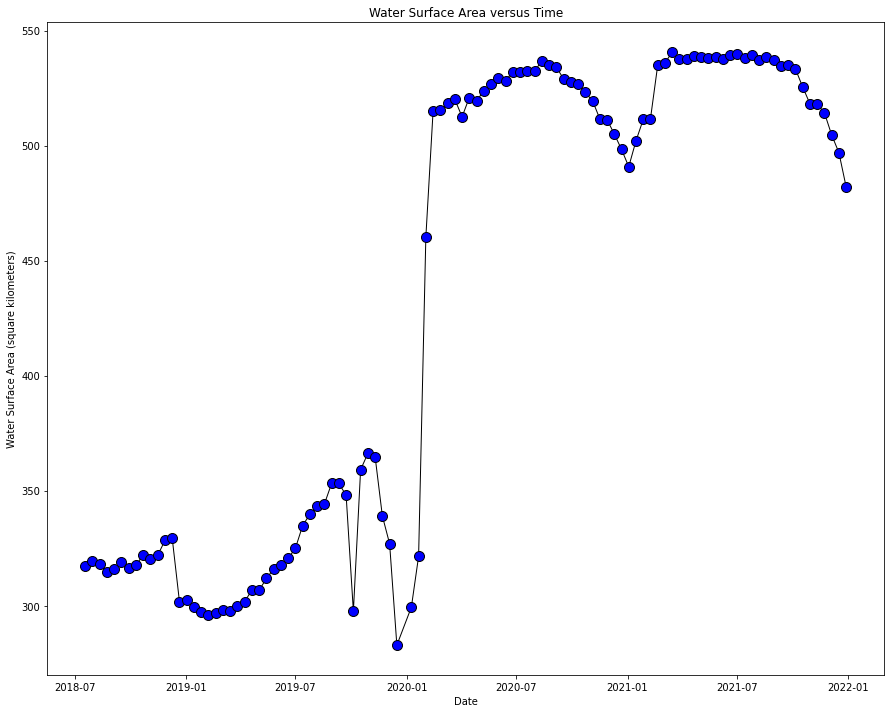

In [ ]:
plt.figure(figsize=(15,12))
plt.plot(scene, water_pixels, c='black', marker='o', mfc='blue', markersize=10, linewidth=1)
plt.title('Water Surface Area versus Time')
plt.xlabel('Date')
plt.ylabel('Water Surface Area (square kilometers)')
plt.show()